# Suite du projet sur la conception de l'application au service de la santé publique

RAPPEL:

L'application que nous voulons créer conciste à se baser sur les informations nutritionnelles des aliements de la base de données Open Food Fact afin de concevoire une applications qui nous permettras de segmenter les aliments. Les étapes de construction de notre application sont:
- Sélection de variables pertinentes à notre étude
- Analyse univariée des variables pertinentes
- Traitement des valeurs manquantes et outliers
- Etude de la corrélation entre nos variables
- Standardisation des variables d'intérêt
- Appliquer l'analyse en composante principale pour la réduction de dimention afin de visualiser les données
- Application de l'algorithme du K-mean pour la segmentation.

Nous avons déjà réalisé le prémier point. Dans cette notebook, nous allons réaliser les autres restant.

In [1]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## I. Chargement de la base des données

Chargeons la base de données que nous avons obtenue à l'issue de la première partie.

In [2]:
dataSelect = pd.read_csv("D:/IML/project2/DATA/dataSelect.csv", sep="\t", index_col = 0)

In [3]:
dataSelect.shape

(526787, 17)

Notre base de données comporte 526787 individus et 17 variables.

In [4]:
#La liste des variables de notre base de données:
dataSelect.columns.tolist()

['energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g',
 'nutrition-score-fr_100g']

In [5]:
dataSelect.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,257715.000000,264614.000000,260846.000000,238048.000000,76505.000000,76056.000000,260534.000000,250034.000000,88980.000000,260590.000000,266220.000000,266220.000000,58911.000000,60910.000000,72580.000000,72084.000000,126785.000000
mean,1114.006447,1114.686673,14.677593,5.707673,0.023763,0.025159,25.538522,13.484149,2.529729,8.797954,1.485916,0.594378,0.000155,0.013766,0.112929,0.002061,8.768932
std,900.350504,900.148899,21.684659,8.684302,0.386054,0.567063,30.935499,22.508470,4.400647,10.224683,9.891979,3.959008,0.000709,0.191379,0.258998,0.050412,9.078239
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000
25%,289.000000,289.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1092.000000,1088.000000,4.500000,1.700000,0.000000,0.000000,8.000000,2.530000,1.000000,5.380000,0.320000,0.128000,0.000000,0.000000,0.024000,0.000710,10.000000
75%,1661.000000,1661.000000,23.000000,8.930000,0.000000,0.015000,53.490000,14.000000,3.600000,15.000000,1.400000,0.560000,0.000107,0.002900,0.109000,0.002400,16.000000
max,41840.000000,41840.000000,100.000000,100.000000,21.430000,83.333000,200.000000,176.000000,100.000000,100.000000,2000.000000,801.000000,0.070000,25.000000,17.188000,13.392900,36.000000


In [6]:
dataSelect.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526787 entries, 2 to 1386296
Data columns (total 17 columns):
energy-kcal_100g           257715 non-null float64
energy_100g                264614 non-null float64
fat_100g                   260846 non-null float64
saturated-fat_100g         238048 non-null float64
trans-fat_100g             76505 non-null float64
cholesterol_100g           76056 non-null float64
carbohydrates_100g         260534 non-null float64
sugars_100g                250034 non-null float64
fiber_100g                 88980 non-null float64
proteins_100g              260590 non-null float64
salt_100g                  266220 non-null float64
sodium_100g                266220 non-null float64
vitamin-a_100g             58911 non-null float64
vitamin-c_100g             60910 non-null float64
calcium_100g               72580 non-null float64
iron_100g                  72084 non-null float64
nutrition-score-fr_100g    126785 non-null float64
dtypes: float64(17)
memory u

# II. Analyse univariée des variables pertinentes

Nous allons scinder nos variables en deux groupes pour optimiser le traitement de valeurs manquantes et des outliers.
- Le premier groupe GrpVar1 est constiuté des variables {'energy-kcal_100g', 'energy_100g', 'nutrition-score-fr_100g'}. Pour ce 1er groupe, nous allons nous servir de l'algorithme des K-NN pour inputer les valeurs manquantes et traiter les outliers.
- Le reste des variables constitura le second groupe GrpVar2. Dans ce groupe nous formulerons une hypothèse forte à savoir qu'une valeur manquante signifie que l'aliment ne comporte pas cette composante nutritionnelle et par conséquent toutes les valeurs manquantes de ce deuxième groupe de varaibles seront inputer par 0. Après l'inputation des valeurs manquantes, nous allons imputer les outliers par la médiane.

In [7]:
GrpVar1 = ['energy-kcal_100g', 'energy_100g', 'nutrition-score-fr_100g']
GrpVar2 = [k for k in dataSelect.columns if k not in GrpVar1]

In [8]:
GrpVar2

['fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

## Treatement des valeurs manquantes et des outliers des varaibles de GrpVar2

In [9]:
# Imputation des valeurs manquantes par 0 sous l'hypothèse formulée ci-dessus

dataSelect[GrpVar2] = dataSelect[GrpVar2].fillna(0)

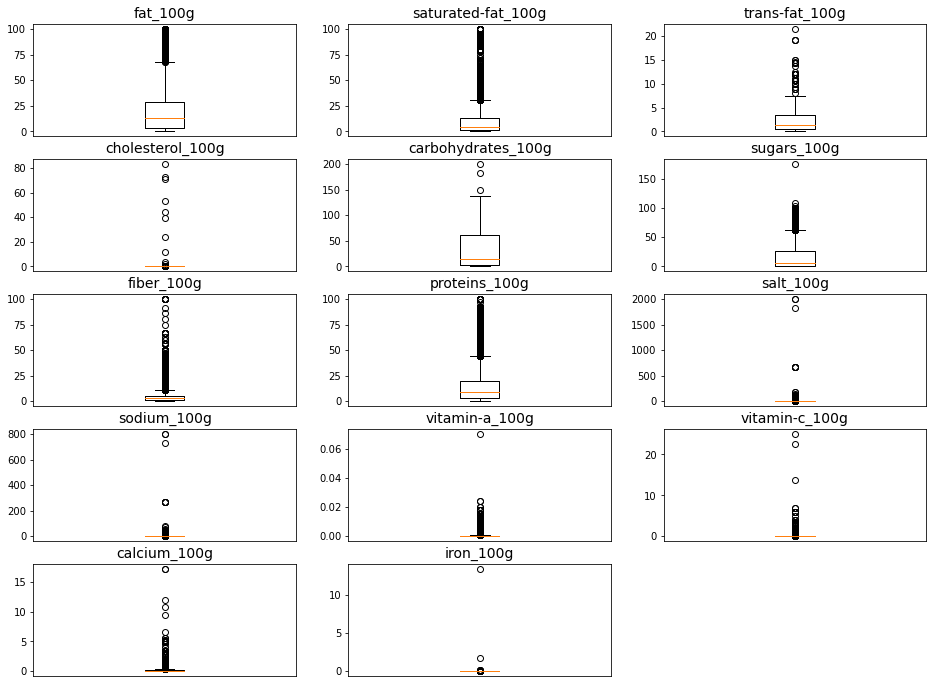

In [10]:
# Analyse des outliers

fig = plt.figure(figsize = (16,12))
for k in range(len(GrpVar2)):
    ax = fig.add_subplot(5, 3, (k+1))
    #h = ax.hist(dataSelect.loc[:,GrpVar2[k]])
    h = ax.boxplot(dataSelect.loc[dataSelect[GrpVar2[k]] != 0,GrpVar2[k]])
    ax.set_title(GrpVar2[k], fontsize = 14)
    ax.set_xticks([])
    ax.set_xticklabels('')

Nous constatons que les variables du groupe GrpVar2 comportent des outliers. Afin d'atténuer l'effet des outliers, nous allons les imputer par la mediane. 

In [11]:
# Imputer les outliers par la médiane 

from sklearn.impute import KNNImputer
for var in GrpVar2:
    Q1 = dataSelect.loc[dataSelect[var] != 0,var].quantile(.25)
    Q2 = dataSelect.loc[dataSelect[var] != 0,var].quantile(.50)
    Q3 = dataSelect.loc[dataSelect[var] != 0,var].quantile(.75)
    IQR = Q3 - Q1
    maxval = Q3 + 1.5*IQR
    minval = Q1 - 1.5*IQR
    dataSelect.loc[dataSelect[var] > maxval,var] = Q2
    dataSelect.loc[dataSelect[var] < minval,var] = Q2

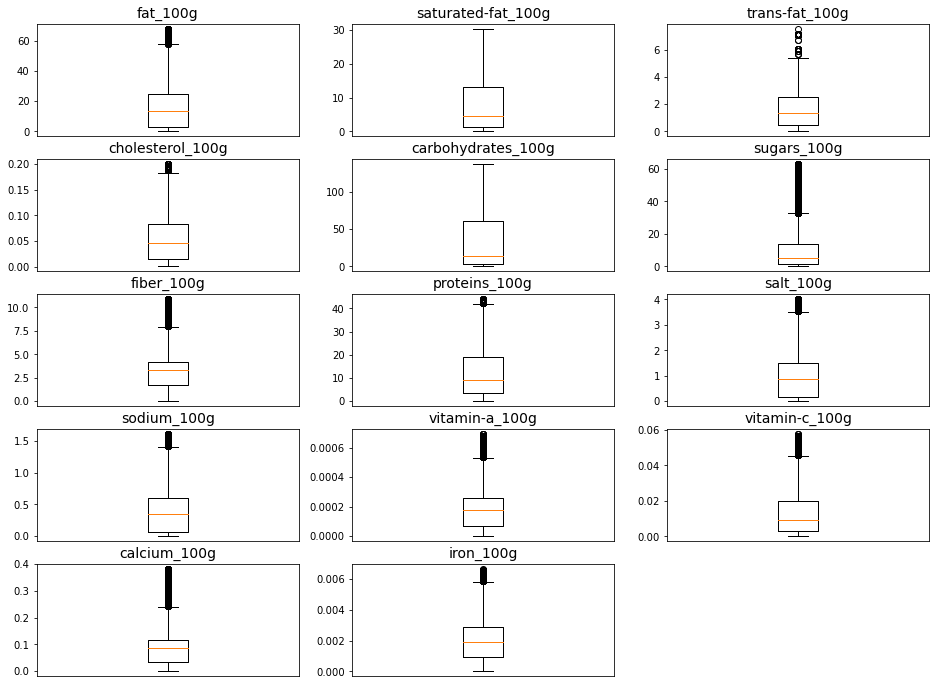

In [12]:
# Analyse des outliers après traitement

fig = plt.figure(figsize = (16,12))
for k in range(len(GrpVar2)):
    ax = fig.add_subplot(5, 3, (k+1))
    h = ax.boxplot(dataSelect.loc[dataSelect[GrpVar2[k]] != 0,GrpVar2[k]])
    ax.set_title(GrpVar2[k], fontsize = 14)
    ax.set_xticks([])
    ax.set_xticklabels('')

Nous constatons une reduction conséquente des outliers au niveau des variables du groupe GrpVar2. 

Après ce traitement, les variables du groupe GrpVar2 ne comportent plus de valeurs manquantes et les outliers sont reduits. 

In [13]:
dataSelect.describe().round(2)

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,257715.00,264614.00,526787.00,526787.00,526787.0,526787.00,526787.00,526787.00,526787.00,526787.0,526787.00,526787.00,526787.0,526787.00,526787.00,526787.00,126785.00
mean,1114.01,1114.69,5.56,2.37,0.0,0.00,12.63,4.30,0.34,4.2,0.36,0.14,0.0,0.00,0.01,0.00,8.77
std,900.35,900.15,11.21,5.38,0.1,0.01,25.22,11.20,1.30,7.8,0.71,0.28,0.0,0.00,0.03,0.00,9.08
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,-14.00
25%,289.00,289.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00
50%,1092.00,1088.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,10.00
75%,1661.00,1661.00,4.20,1.00,0.0,0.00,7.50,2.00,0.00,5.2,0.34,0.14,0.0,0.00,0.00,0.00,16.00
max,41840.00,41840.00,68.00,30.30,7.5,0.20,137.00,63.04,10.90,44.0,4.02,1.61,0.0,0.06,0.38,0.01,36.00


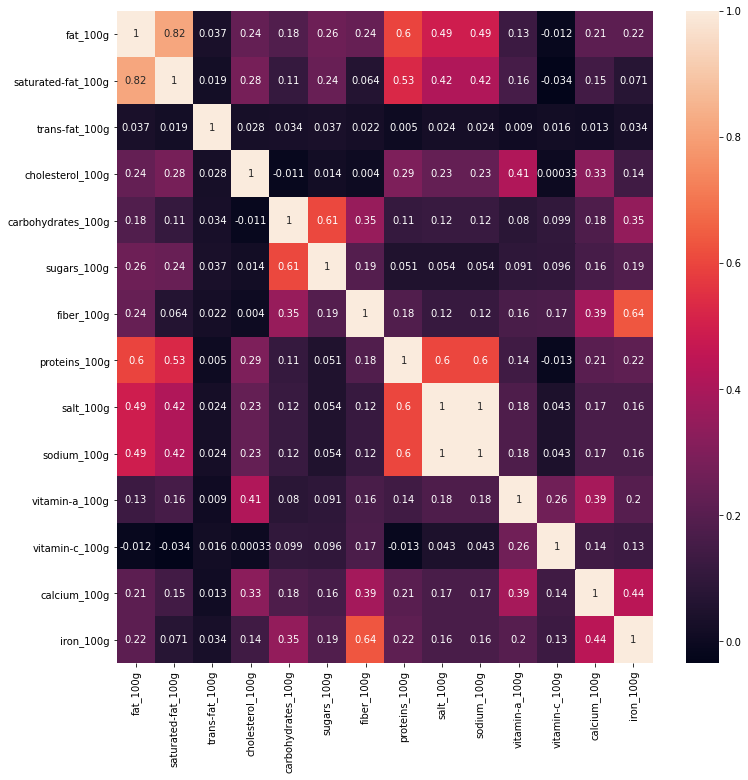

In [14]:
#Etudions la corrélation entre nos variables
corrMatrix = dataSelect[GrpVar2].corr(method = 'pearson')
# Heatmap plot
plt.figure(figsize = (12,12))
sns.heatmap(corrMatrix, annot = True)
plt.show()

Nous constatons que les variables ***fat_100g*** et ***saturated-fat_100g*** sont hautement correlées et par conséquent en se basant sur leur pourcentage de données manquantes, nous allons supprimer la variable ***saturated-fat_100g*** de notre base de données.

Il en est de même des variables ***salt_100g*** et ***sodium_100g***. Nous supprimerons la variable ***sodium_100g*** parce qu'il presente plus de données manquantes que ***salt_100g***.

In [15]:
#Suppression des variables saturated-fat_100g et sodium_100g de notre base de données.
dataSelect.drop(['saturated-fat_100g', 'sodium_100g'], axis = 1, inplace = True)

## Treatement des valeurs manquantes et des outliers des varaibles de GrpVar1

In [16]:
#Etudions la corrélation entre les variables energy-kcal_100g et energy_100g
dataSelect[['energy-kcal_100g', 'energy_100g']].corr(method='pearson')

,energy-kcal_100g,energy_100g
energy-kcal_100g,1.000000,0.999996
energy_100g,0.999996,1.000000


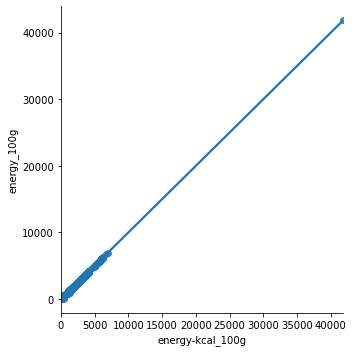

In [17]:
sns.lmplot(x="energy-kcal_100g", y="energy_100g", data=dataSelect);

Nous avons une très forte corrélation entre ces deux variables. Nous allons alors supprimer la variable ***energy-kcal_100g*** qui comporte plus de valeurs manquantes (soit 24%) que la variable ***energy_100g*** (soit 19%).

In [18]:
#suppression de la variable energy-kcal_100g pour cause de corrélation
dataSelect.drop(['energy-kcal_100g'], axis = 1, inplace = True)

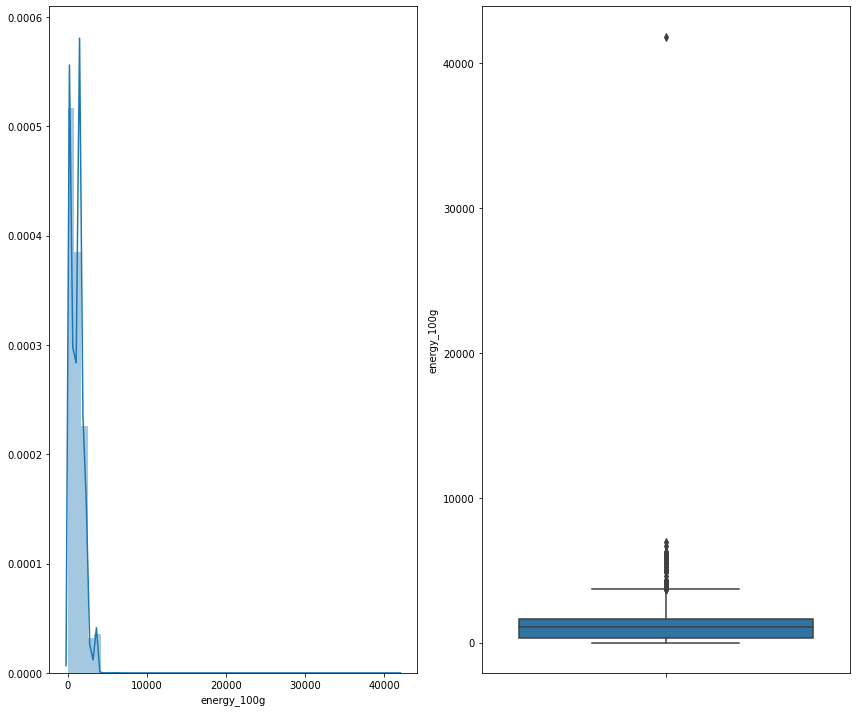

In [19]:
#Visualisation des outliers de la variable energy_100g

plt.figure(figsize = (12,10))
plt.subplot(1,2,1)
sns.distplot(dataSelect[dataSelect['energy_100g'].notnull()]['energy_100g'])
plt.subplot(1,2,2)
sns.boxplot(x = None, y = dataSelect['energy_100g'])
plt.tight_layout()
plt.show()

On denote une presence de outliers au niveau de cette variable. Nous allons imputer les outliers par des données manquantes et revoir la distribution de la variable.

In [20]:
# Imputation des outliers par des NaN

Q1 = dataSelect.loc[dataSelect['energy_100g'] != 0,'energy_100g'].quantile(.25)
Q3 = dataSelect.loc[dataSelect['energy_100g'] != 0,'energy_100g'].quantile(.75)
IQR = Q3 - Q1
maxval = Q3 + 1.5*IQR
minval = Q1 - 1.5*IQR
dataSelect.loc[dataSelect['energy_100g'] > maxval,'energy_100g'] = NaN
dataSelect.loc[dataSelect['energy_100g'] < minval,'energy_100g'] = NaN

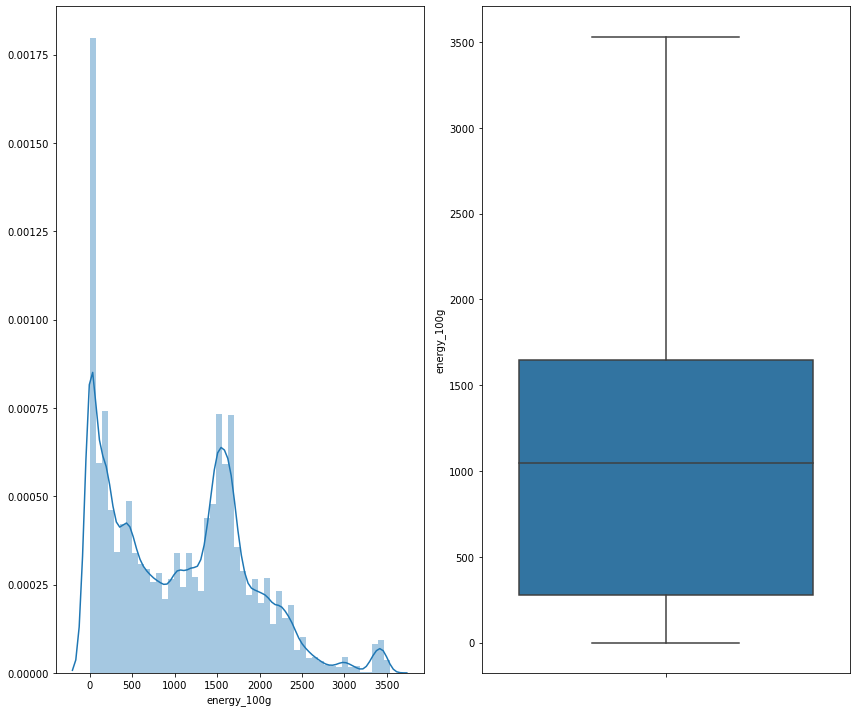

In [21]:
# Distribution de la variable energy_100g après imputation des outliers par les NaN

plt.figure(figsize = (12,10))
plt.subplot(1,2,1)
sns.distplot(dataSelect[dataSelect['energy_100g'].notnull()]['energy_100g'])
plt.subplot(1,2,2)
sns.boxplot(x = None, y = dataSelect['energy_100g'])
plt.tight_layout()
plt.show()

Nous allons utiliser l'algorithme des K plus proche voisins (régression) pour imputer toutes les valeurs manquantes de la variable ***energy_100g***. Pour ce faire, nous allons d'abord scinder notre base de données en deux parties. La première partie ***dt1*** est constituée des aliments dont la variable ***energy_100g*** est renseignée et la deuxième ***dt2*** celle dont la variable ***energy_100g*** est manquante. Ensuite, nous utiliserons ***dt1*** pour entrainer notre model et enfin nous utiliserons ***dt2*** pour predire les valeurs manquantes de la variable ***energy_100g***.

In [22]:
#Scinder notre base de données dataSelect en deux parties

dt1 = dataSelect[dataSelect['energy_100g'].notnull()]
dt2 = dataSelect[dataSelect['energy_100g'].isnull()].drop(['energy_100g', 'nutrition-score-fr_100g'], axis = 1)

In [23]:
# Utiliser la base dt1 pour definir les données et la cible(target)

X1 = dt1.drop(['energy_100g', 'nutrition-score-fr_100g'], axis = 1).values
y1 = dt1['energy_100g'].values

In [24]:
# Utilisation de X1 et y1 pour entrainer le modèle KNeighborsRegressor en validation croisée 
# en considérant 5 folds et en faisant une recherche optimale de l'hyperparamètre n_neighbors.

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

reg = GridSearchCV(KNeighborsRegressor(), 
                  {'n_neighbors':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
                  cv = 5)
reg.fit(X1, y1)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100]})

In [25]:
#La meilleure valeur de l'hyperparamètre
reg.best_params_

{'n_neighbors': 10}

Notre modèle a retenue les 10 plus proche voisins comme meilleur hyperparamètre parmis les hyperparamètres proposés.

In [26]:
#Utilisation de dt2 pour predire les valeurs manquantes

y_pred = reg.predict(dt2)

In [27]:
#Imputation des valeurs manquantes par les données predites par le modèle KNeighborsRegressor

dataSelect.loc[dataSelect['energy_100g'].isnull(),'energy_100g'] = y_pred

A ce niveau, la variable ***energy_100g*** ne comporte plus de données manquantes et les outliers ont été réduits.

Nous allons utiliser l'algorithme des K plus proche voisins (classification) pour imputer toutes les valeurs manquantes de la variable ***nutrition-score-fr_100g***. Pour ce faire, nous allons d'abord scinder notre base de données en deux parties. La première partie ***dts1*** est constituée des aliments dont la variable ***nutrition-score-fr_100g*** est renseignée et la deuxième ***dts2*** celle dont la variable ***nutrition-score-fr_100g*** est manquante. Ensuite, nous utiliserons ***dts1*** pour entrainer notre model et enfin nous utiliserons ***dts2*** pour predire les valeurs manquantes de la variable ***nutrition-score-fr_100g***.

In [28]:
#Scinder notre base de données dataSelect en deux parties suivant que nutrition-score-fr_100g est manquante ou non

dts1 = dataSelect[dataSelect['nutrition-score-fr_100g'].notnull()]
dts2 = dataSelect[dataSelect['nutrition-score-fr_100g'].isnull()].drop(['nutrition-score-fr_100g'], axis = 1)

In [29]:
# Utiliser la base dts1 pour definir les données et la cible(target) pour l'entrainement de notre modèle

Xs1 = dts1.drop(['nutrition-score-fr_100g'], axis = 1).values
ys1 = dts1['nutrition-score-fr_100g'].values

In [32]:
# Utilisation de Xs1 et ys1 pour entrainer le modèle KNeighborsClassifier en considérant les 5 plus proches voisins

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(KNeighborsClassifier(), 
                  {'n_neighbors':list(range(1,11))},
                  cv = 5,
                  scoring = 'accuracy')
clf.fit(Xs1, ys1)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [33]:
#La meilleure valeur de l'hyperparamètre
clf.best_params_

{'n_neighbors': 1}

Notre modèle a retenue le plus proche voisins comme meilleur hyperparamètre parmis les hyperparamètres proposés.

In [34]:
#Utilisation de dts2 pour predire les valeurs manquantes

ys_pred = clf.predict(dts2)

In [35]:
#Imputation des valeurs manquantes par les données predites par le modèle KNeighborsClassifier

dataSelect.loc[dataSelect['nutrition-score-fr_100g'].isnull(), 'nutrition-score-fr_100g'] = ys_pred

In [36]:
dataSelect.describe()

,energy_100g,fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000,526787.000000
mean,637.329758,5.563019,0.002624,0.002487,12.629705,4.295365,0.340688,4.204699,0.361210,0.000008,0.000485,0.007524,0.000170,4.390731
std,778.232949,11.208976,0.098012,0.013980,25.222709,11.198927,1.302971,7.796947,0.706726,0.000047,0.003521,0.032914,0.000689,7.548880
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000
25%,163.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,163.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1100.000000,4.200000,0.000000,0.000000,7.500000,2.000000,0.000000,5.200000,0.340500,0.000000,0.000000,0.000000,0.000000,10.000000
max,3531.000000,68.000000,7.500000,0.200000,137.000000,63.040000,10.900000,44.000000,4.017500,0.000692,0.057700,0.382000,0.006650,36.000000


A cette étape de notre analyse, nos données sont sans valeurs manquantes. En outre, nous avons considérablement réduits les outiliers.

In [37]:
#Etudions la corrélation entre nos variables

corrMatrix = dataSelect.corr(method = 'pearson')

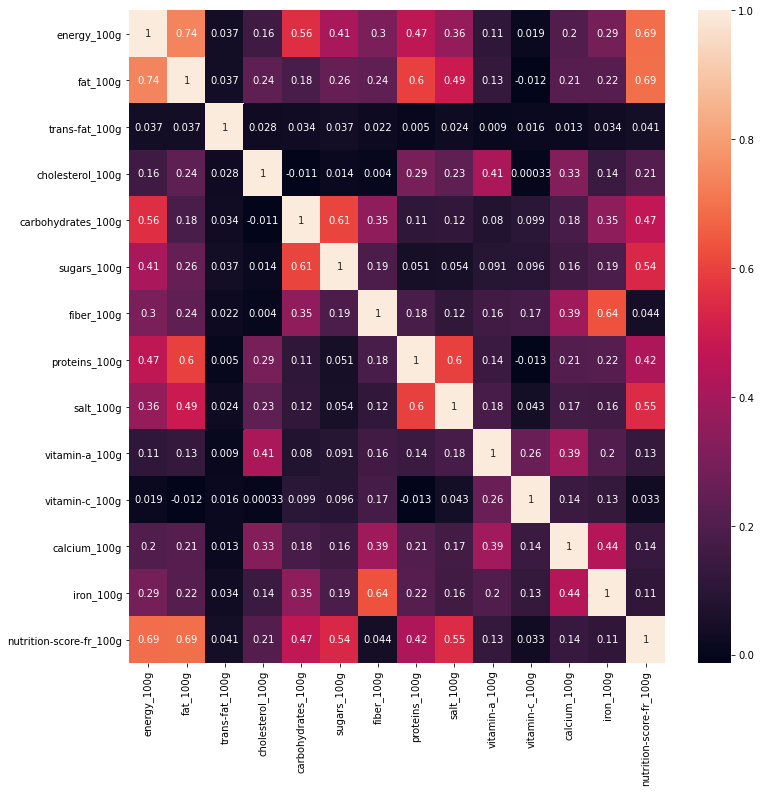

In [38]:
# Heatmap plot
plt.figure(figsize = (12,12))
sns.heatmap(corrMatrix, annot = True)
plt.show()

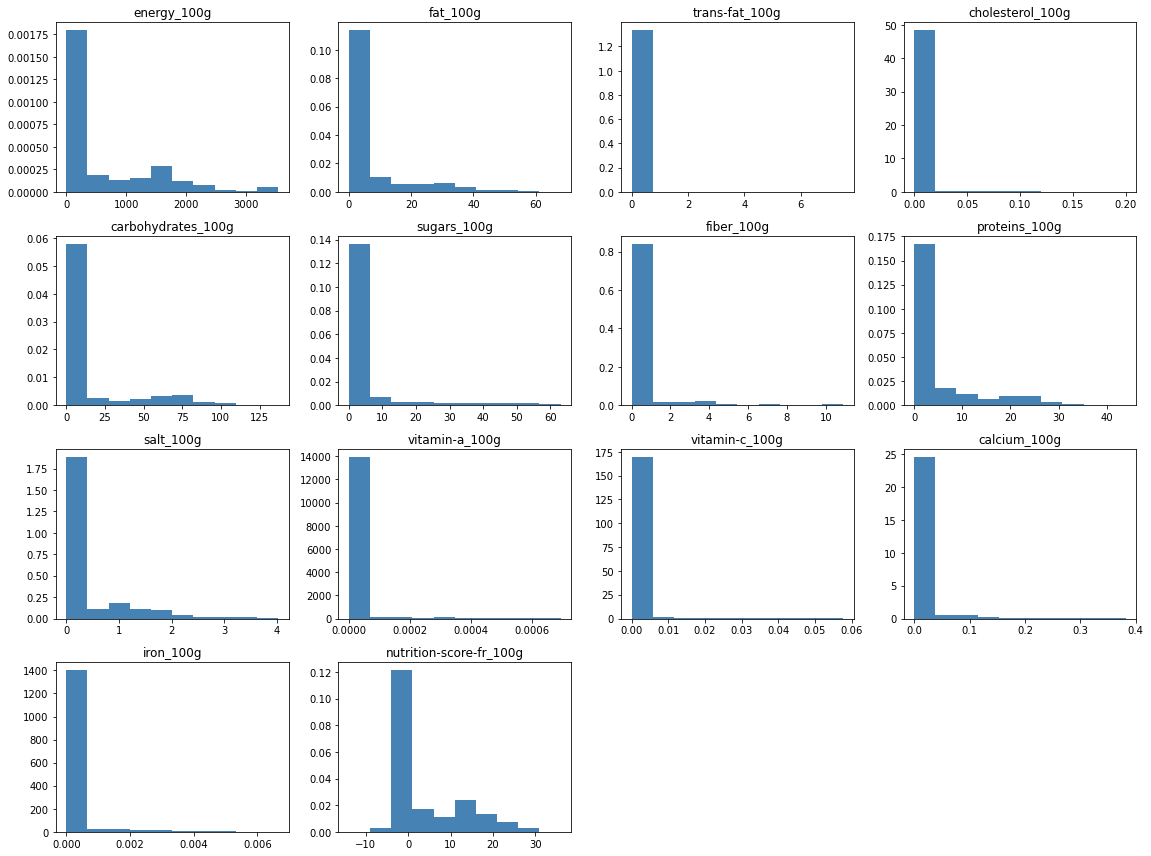

In [39]:
#Distribution des variables
fig = plt.figure(figsize = (16,12))
for k in range(dataSelect.shape[1]):
    ax = fig.add_subplot(4, 4, (k+1))
    h = ax.hist(dataSelect.iloc[:,k], bins = 10, color='steelblue', density = True, edgecolor = 'none')
    ax.set_title(dataSelect.columns[k], fontsize = 12)
plt.tight_layout()
plt.show()

Nous constatons qu'aucune de nos variables ne suit la loi normale. Par consconséquent, en vu d'implementer la reduction de dimension nous allons normaliser nos variables plutôt que de les standardiser. Pour cela nous ferons recourt à la fonction MinMaxScaler de la classe preprocessing du module sklearn.

## Normalisation des variables de notre base de données

In [40]:
#Normalisation des données
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()
dataSelect_Nor = norm.fit_transform(dataSelect)

Après la normalisation des données, nous pouvons alors passer à la réduction de dimention de notre base de données en faisant l'analyse en composante principale. Nous utiliserons la fonction PCA de la classe decomposition du module sklearn.

## Réduction de dimention de notre base de données

In [41]:
#utilisation de l'algorithme PCA pour la reduction de dimension

from sklearn.decomposition import PCA
pca = PCA(random_state = 10)
pca.fit(dataSelect_Nor)

PCA(random_state=10)

In [42]:
#Contribution de chaque axe principal à la variabilité des données.
pca.explained_variance_ratio_.round(3)

array([0.454, 0.18 , 0.084, 0.075, 0.052, 0.044, 0.029, 0.019, 0.017,
       0.014, 0.013, 0.011, 0.008, 0.001])

In [43]:
# Recherche du notre d'axes à rétenir pour garder 80% de l'information
pca.explained_variance_ratio_.cumsum().round(3)

array([0.454, 0.634, 0.718, 0.793, 0.845, 0.889, 0.917, 0.937, 0.953,
       0.967, 0.98 , 0.991, 0.999, 1.   ])

Pour une meilleure representativité de la contribution des axes principaux à la variabilité des données, nous allons effectuer le ***scree plot***. Il representera sur le même graphe, le pourcentage de variance expliqué et le ppourcentage cumulé de variance expliqué par les axes principaux.

In [44]:
def display_scree_plot(pca):
    '''Le scree plot de l'analyse en composante principale'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Pourcentage de la variance expliquée")
    plt.title("Scree plot")
    plt.show(block=False)

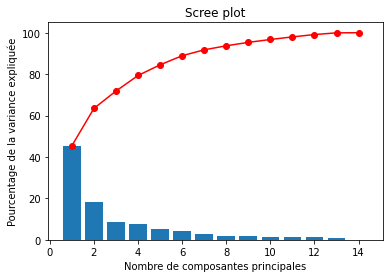

In [45]:
display_scree_plot(pca) 

Avec les 7 premiers axes principaux, nous avons plus de 90% de la variabilité totale. Nous retiendrons alors les 7 premiers axes principaux pour la transformation.

In [46]:
pca2 = PCA(n_components=7, random_state = 10)
pca2.fit(dataSelect_Nor)
FinalData = pca2.transform(dataSelect_Nor)

Après la transformation de notre base de données, nous allons proceder à la segmentation. Mais ne sachant pas à priori le nombre de segments à considérer, nous allons representer le **Elbow plot** et ainsi determiner le nombre optimal de segments à retenir.

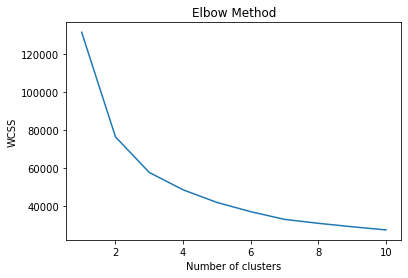

In [47]:
# Determination du meilleur hyperparamètre K dans le model KMeans 
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=5)
    kmeans.fit(FinalData)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

D'après le **Elbow plot**, le meilleur hyperparamètre à retenir pour notre segmentation serait 3. Dans la suite, nous garderons 3 segments.

In [48]:
#Entrainement et prediction du model KMeans à la recherche de 3 segements dans notre base de données.

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=5)
pred_y = kmeans.fit_predict(FinalData)

In [49]:
#Reconstruire la base de données en y ajoutant la variable Classe qui représente les classes obtenues après la segmentation.
dataSelect2 = pd.DataFrame(dataSelect_Nor, index=dataSelect.index, columns=dataSelect.columns)
dataSelect2['Class'] = pred_y

In [50]:
dataSelect2.head()

,energy_100g,fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,Class
2,0.046191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,1
4,0.046191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,1
7,0.046191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,1
8,0.046191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,1
9,0.046191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,1


In [51]:
#Détermination du nombre d'aliments par classe.
dataSelect2['Class'].value_counts()

1    354165
2     94909
0     77713
Name: Class, dtype: int64

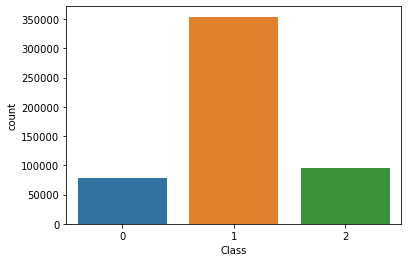

In [52]:
#Distribution des classes obtenues après la segmentation

sns.countplot(dataSelect2['Class'])

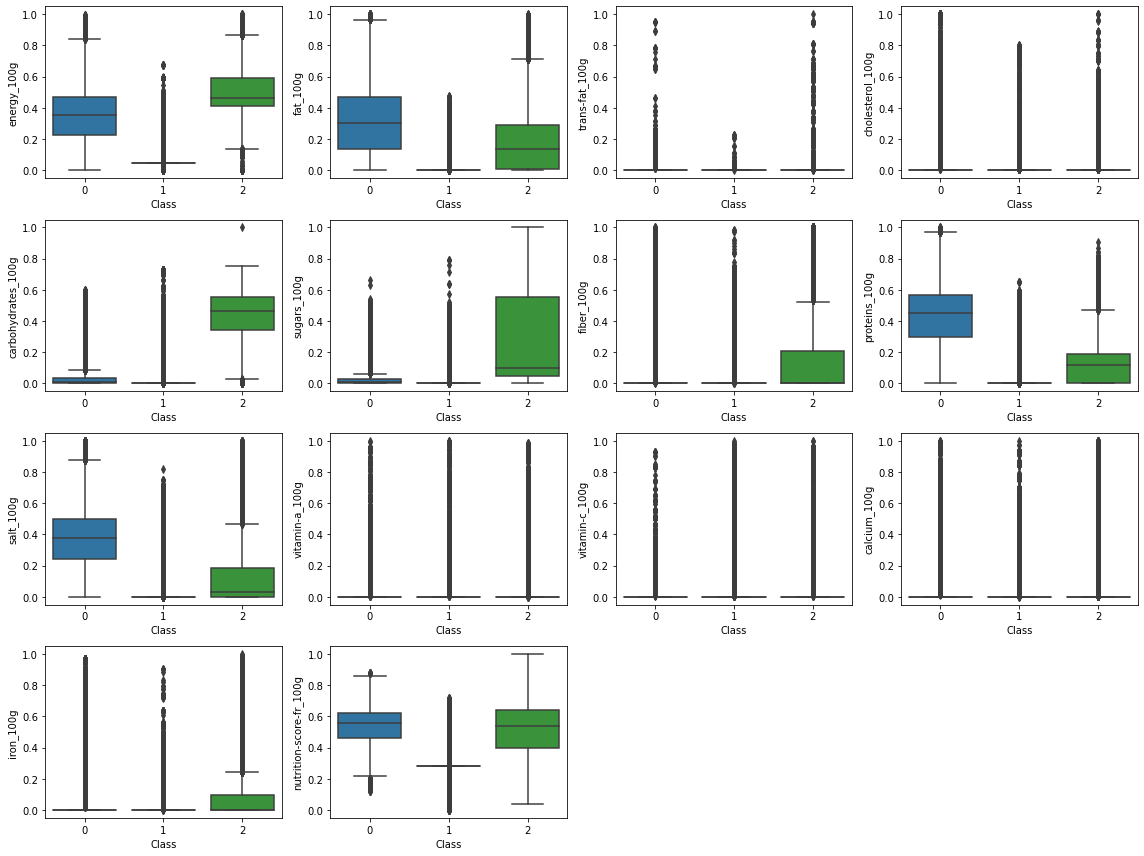

In [53]:
#Distribution des variables par classe

fig = plt.figure(figsize = (16,12))
for k in range(dataSelect2.shape[1] - 1):
    ax = fig.add_subplot(4, 4, (k+1))
    sns.boxplot(dataSelect2.iloc[:,-1], dataSelect2.iloc[:,k])
plt.tight_layout()
plt.show()

## Etudions les caractéristiques principales de chaque groupes

Pour étudier les caractéristiques principales de groupes obtenus à l'issue de la segmentation, nous allons effectuer le **parallel coordinates plot**.

In [54]:
from pandas.plotting import parallel_coordinates

palette = sns.color_palette("bright", 10)

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.Class==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'Class', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'Class', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20) 

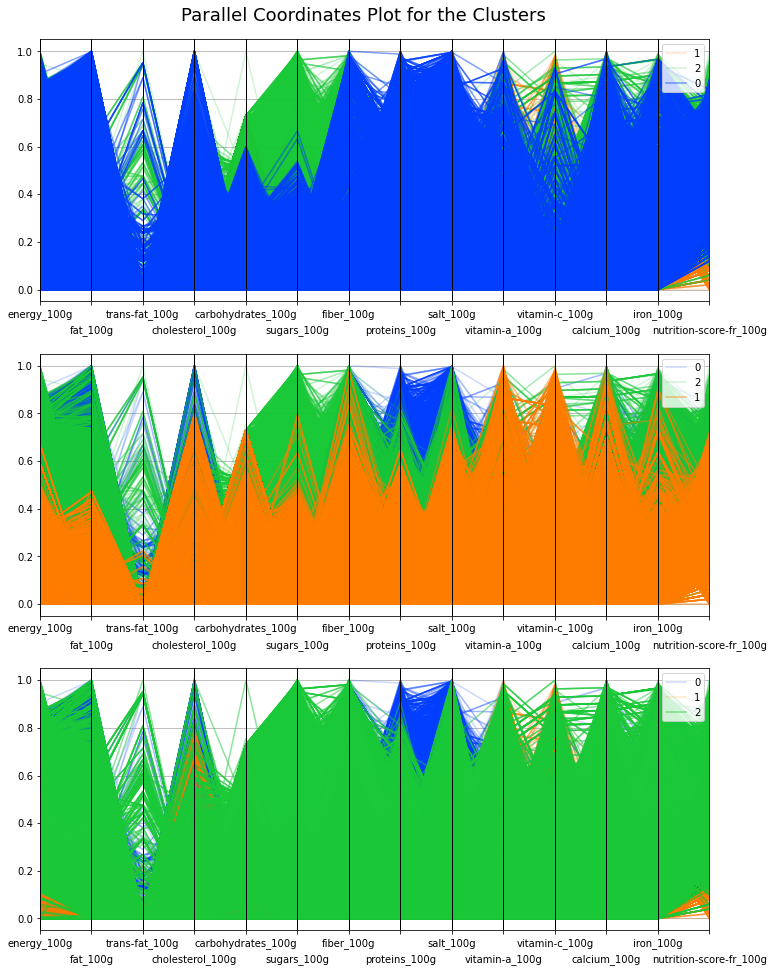

In [55]:
# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(dataSelect2, 3)

Notre base de données est constituée principalement des aliments du groupe 1. D'après le graphique ci-dessus, nous constatons que les aliments du groupe 1 contiennent plus de vitamine et de clacium et moins de sucre, de graisse et de protéines. Leurs valeurs energétiques sontt relativement faibles. Ces types d'aliments conviennent à ceux qui sont en régime alimentaire ou bien à ceux qui sont malade du diabète où  de la tension.

Le groupe 2 et le grouoe 0 sont assez similaires. Cependant, la plupart des aliments du groupe 0 ont une faible concentration en sucre et en carbohydrates et une forte concentration en protéine. Les aliments du groupe 2 sont juste légèrement moins concentrés en protéine. Nous pouvons conseiller les aliments du groupe 2 aux malnutris. La consommation trop abusive des aliments du groupe 2 peuvent être dangereuse pour la santé. Bien que les personnes diabétique peuvent consommer les aliments du type 0 (car non trop concentré en sucre), nous ne les conseillerons pas d'en abuser.  

In [56]:
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'Class', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

In [57]:
kmeans.cluster_centers_

array([[ 0.42394037, -0.37275498, -0.02991433,  0.04839533, -0.0014128 ,
         0.02241216, -0.00191369],
       [-0.22413635,  0.00568044, -0.00172914, -0.00202684,  0.01561551,
        -0.00737994, -0.00099882],
       [ 0.48909513,  0.2834096 ,  0.03088915, -0.03198928, -0.05705488,
         0.00919656,  0.00528697]])

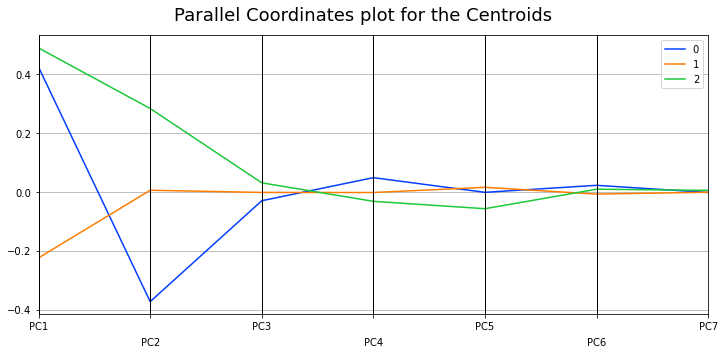

In [59]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
centroids['Class'] = centroids.index

display_parallel_coordinates_centroids(centroids, 3)

In [64]:
pd.Series(pca.components_[0], index=list(dataSelect.columns)).sort_values(ascending = False)

energy_100g                0.564560
fat_100g                   0.377995
nutrition-score-fr_100g    0.359139
carbohydrates_100g         0.326594
proteins_100g              0.319471
salt_100g                  0.295373
sugars_100g                0.278215
fiber_100g                 0.122949
iron_100g                  0.110049
calcium_100g               0.071995
cholesterol_100g           0.046474
vitamin-a_100g             0.036743
vitamin-c_100g             0.010716
trans-fat_100g             0.001640
dtype: float64

In [65]:
pd.Series(pca.components_[1], index=list(dataSelect.columns)).sort_values(ascending = False)

carbohydrates_100g         0.523375
sugars_100g                0.502459
fiber_100g                 0.091604
energy_100g                0.066186
iron_100g                  0.060222
vitamin-c_100g             0.025589
calcium_100g               0.003054
nutrition-score-fr_100g    0.001780
trans-fat_100g             0.000989
vitamin-a_100g            -0.017061
cholesterol_100g          -0.075286
fat_100g                  -0.237889
salt_100g                 -0.433724
proteins_100g             -0.453740
dtype: float64

Le graphique ci-dessus nous permet de voire que suivant le deuxième axe principal, les groupe 2 et 0 sont bien différents. Et après analyse de la contribution des variables aux deux premiers axes principaux, nous confirmons notre analyse ci-dessus.

# FIN DE L'APPLICATION